# Installation of Modules

In [ ]:
!git clone https://github.com/explainingai-code/Yolov1-PyTorch.git

Cloning into 'Yolov1-PyTorch'...
remote: Enumerating objects: 53, done.
remote: Counting objects: 100% (53/53), done.
remote: Compressing objects: 100% (41/41), done.
remote: Total 53 (delta 20), reused 39 (delta 11), pack-reused 0 (from 0)
Unpacking objects: 100% (53/53), 23.58 KiB | 1.39 MiB/s, done.


In [ ]:
%cd Yolov1-PyTorch

/data/teja/yolov5_tutorial/yolo/Yolov1-PyTorch


In [ ]:
!pip install albumentations

  Using cached numpy-1.24.4-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (5.6 kB)
  Using cached scikit_image-0.21.0-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (14 kB)
  Using cached opencv_python_headless-4.10.0.84-cp37-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (20 kB)
  Using cached tifffile-2023.7.10-py3-none-any.whl.metadata (31 kB)
  Using cached PyWavelets-1.4.1-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (1.9 kB)
  Using cached lazy_loader-0.4-py3-none-any.whl.metadata (7.6 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.3/200.3 kB 2.1 MB/s eta 0:00:002.6 MB/s eta 0:00:01
Using cached numpy-1.24.4-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (17.3 MB)
Using cached opencv_python_headless-4.10.0.84-cp37-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (49.9 MB)
Using cached scikit_image-0.21.0-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (13.9 MB)
Using cached lazy_l

# Getting the dataset

In [ ]:
%cd Yolov1-PyTorch
!mkdir data
%cd data
!wget http://host.robots.ox.ac.uk/pascal/VOC/voc2007/VOCtrainval_06-Nov-2007.tar
!tar xf /content/Yolov1-PyTorch/data/VOCtrainval_06-Nov-2007.tar
!mv /content/Yolov1-PyTorch/data/VOCdevkit/VOC2007 /content/Yolov1-PyTorch/data
!rm -r /content/Yolov1-PyTorch/data/VOCdevkit/VOC2007
!wget http://host.robots.ox.ac.uk/pascal/VOC/voc2007/VOCtest_06-Nov-2007.tar
!tar xf /content/Yolov1-PyTorch/data/VOCtest_06-Nov-2007.tar
!mv /content/Yolov1-PyTorch/data/VOCdevkit/VOC2007 /content/Yolov1-PyTorch/data/VOC2007-test

# Training the yolo model

In [ ]:
import os
os.chdir('Yolov1-PyTorch')
import torch
import argparse
import os
import numpy as np
import yaml
import random
from models.yolo import YOLOV1
from tqdm import tqdm
from dataset.voc import VOCDataset
from torch.utils.data.dataloader import DataLoader
from torch.optim.lr_scheduler import MultiStepLR
from loss.yolov1_loss import YOLOV1Loss

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

if torch.backends.mps.is_available():
    device = torch.device('mps')
    print('Using mps')


def collate_function(data):
    return list(zip(*data))

/home/user/miniconda3/envs/flare-mamba/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
def train(args):
    # Read the config file #
    with open(args.config_path, 'r') as file:
        try:
            config = yaml.safe_load(file)
        except yaml.YAMLError as exc:
            print(exc)
    print(config)
    ########################

    dataset_config = config['dataset_params']
    model_config = config['model_params']
    train_config = config['train_params']

    seed = train_config['seed']
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    if device == 'cuda':
        torch.cuda.manual_seed_all(seed)

    voc = VOCDataset('train',
                     im_sets=dataset_config['train_im_sets'])
    train_dataset = DataLoader(voc,
                               batch_size=train_config['batch_size'],
                               shuffle=True,
                               collate_fn=collate_function)

    yolo_model = YOLOV1(im_size=dataset_config['im_size'],
                        num_classes=dataset_config['num_classes'],
                        model_config=model_config)
    yolo_model.train()
    yolo_model.to(device)
    if os.path.exists(os.path.join(train_config['task_name'],
                                   train_config['ckpt_name'])):
        print('Loading checkpoint as one exists')
        yolo_model.load_state_dict(torch.load(
            os.path.join(train_config['task_name'],
                         train_config['ckpt_name']),
            map_location=device))
    if not os.path.exists(train_config['task_name']):
        os.mkdir(train_config['task_name'])

    optimizer = torch.optim.SGD(lr=train_config['lr'],
                                params=filter(lambda p: p.requires_grad,
                                              yolo_model.parameters()),
                                weight_decay=5E-4,
                                momentum=0.9)

    scheduler = MultiStepLR(optimizer, milestones=train_config['lr_steps'], gamma=0.5)
    criterion = YOLOV1Loss()
    acc_steps = train_config['acc_steps']
    num_epochs = train_config['num_epochs']
    steps = 0
    for epoch_idx in range(num_epochs):
        losses = []
        optimizer.zero_grad()
        for idx, (ims, targets, _) in enumerate(tqdm(train_dataset)):
            yolo_targets = torch.cat([
                target['yolo_targets'].unsqueeze(0).float().to(device)
                for target in targets], dim=0)
            im = torch.cat([im.unsqueeze(0).float().to(device) for im in ims], dim=0)
            yolo_preds = yolo_model(im)
            loss = criterion(yolo_preds, yolo_targets, use_sigmoid=model_config['use_sigmoid'])
            loss = loss / acc_steps
            loss.backward()
            losses.append(loss.item())
            if (idx + 1) % acc_steps == 0:
                optimizer.step()
                optimizer.zero_grad()
            if steps % train_config['log_steps'] == 0:
                print('Loss : {:.4f}'.format(np.mean(losses)))
            if torch.isnan(loss):
                print('Loss is becoming nan. Exiting')
                exit(0)
            steps += 1
        print('Finished epoch {}'.format(epoch_idx+1))
        optimizer.step()
        optimizer.zero_grad()
        scheduler.step()
        torch.save(yolo_model.state_dict(), os.path.join(train_config['task_name'],
                                                         train_config['ckpt_name']))
    print('Done Training...')

In [ ]:
# Define the configuration path directly (replace with your actual config path if needed)
config_path = 'config/voc.yaml'

# Simulate argparse args
class Args:
    def __init__(self, config_path):
        self.config_path = config_path

# Create an args instance
args = Args(config_path)

# Call the training function with the provided arguments
train(args)

{'dataset_params': {'train_im_sets': ['data/VOC2007'], 'test_im_sets': ['data/VOC2007-test'], 'num_classes': 20, 'im_size': 448}, 'model_params': {'im_channels': 3, 'backbone_channels': 512, 'conv_spatial_size': 7, 'yolo_conv_channels': 1024, 'leaky_relu_slope': 0.1, 'fc_dim': 4096, 'fc_dropout': 0.5, 'S': 7, 'B': 2, 'use_sigmoid': True, 'use_conv': True}, 'train_params': {'task_name': 'voc', 'seed': 1111, 'acc_steps': 1, 'log_steps': 100, 'num_epochs': 5, 'batch_size': 64, 'lr_steps': [50, 75, 100, 125], 'lr': 0.001, 'infer_conf_threshold': 0.2, 'eval_conf_threshold': 0.001, 'nms_threshold': 0.5, 'ckpt_name': 'yolo_voc2007.pth'}}
{0: 'aeroplane', 1: 'bicycle', 2: 'bird', 3: 'boat', 4: 'bottle', 5: 'bus', 6: 'car', 7: 'cat', 8: 'chair', 9: 'cow', 10: 'diningtable', 11: 'dog', 12: 'horse', 13: 'motorbike', 14: 'person', 15: 'pottedplant', 16: 'sheep', 17: 'sofa', 18: 'train', 19: 'tvmonitor'}
Total 5011 images found
Loading checkpoint as one exists


  1%|▏         | 1/79 [00:00<01:02,  1.24it/s]

Loss : 2.8362


100%|██████████| 79/79 [00:46<00:00,  1.70it/s]


Finished epoch 1


 28%|██▊       | 22/79 [00:13<00:33,  1.70it/s]

Loss : 2.3645


100%|██████████| 79/79 [00:46<00:00,  1.71it/s]


Finished epoch 2


 54%|█████▍    | 43/79 [00:24<00:21,  1.70it/s]

Loss : 2.5087


100%|██████████| 79/79 [00:45<00:00,  1.75it/s]


Finished epoch 3


 81%|████████  | 64/79 [00:37<00:08,  1.76it/s]

Loss : 2.3731


100%|██████████| 79/79 [00:45<00:00,  1.72it/s]


Finished epoch 4


100%|██████████| 79/79 [00:45<00:00,  1.74it/s]


Finished epoch 5
Done Training...


# Inference on sample Images

In [ ]:
import torch
import argparse
import os
import yaml
import random
from tqdm import tqdm
from models.yolo import YOLOV1
from dataset.voc import VOCDataset
from utils.visualization_utils import *
from torch.utils.data.dataloader import DataLoader
import cv2

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


def get_iou(det, gt):
    det_x1, det_y1, det_x2, det_y2 = det
    gt_x1, gt_y1, gt_x2, gt_y2 = gt

    x_left = max(det_x1, gt_x1)
    y_top = max(det_y1, gt_y1)
    x_right = min(det_x2, gt_x2)
    y_bottom = min(det_y2, gt_y2)

    if x_right < x_left or y_bottom < y_top:
        return 0.0

    area_intersection = (x_right - x_left) * (y_bottom - y_top)
    det_area = (det_x2 - det_x1) * (det_y2 - det_y1)
    gt_area = (gt_x2 - gt_x1) * (gt_y2 - gt_y1)
    area_union = float(det_area + gt_area - area_intersection + 1E-6)
    iou = area_intersection / area_union
    return iou


def compute_map(det_boxes, gt_boxes, iou_threshold=0.5, method='area', difficult=None):
    # det_boxes = [
    #   {
    #       'person' : [[x1, y1, x2, y2, score], ...],
    #       'car' : [[x1, y1, x2, y2, score], ...]
    #   }
    #   {det_boxes_img_2},
    #   ...
    #   {det_boxes_img_N},
    # ]
    #
    # gt_boxes = [
    #   {
    #       'person' : [[x1, y1, x2, y2], ...],
    #       'car' : [[x1, y1, x2, y2], ...]
    #   },
    #   {gt_boxes_img_2},
    #   ...
    #   {gt_boxes_img_N},
    # ]

    gt_labels = {cls_key for im_gt in gt_boxes for cls_key in im_gt.keys()}
    gt_labels = sorted(gt_labels)

    all_aps = {}
    # average precisions for ALL classes
    aps = []
    for idx, label in enumerate(gt_labels):
        # Get detection predictions of this class
        cls_dets = [
            [im_idx, im_dets_label] for im_idx, im_dets in enumerate(det_boxes)
            if label in im_dets for im_dets_label in im_dets[label]
        ]

        # cls_dets = [
        #   (0, [x1_0, y1_0, x2_0, y2_0, score_0]),
        #   ...
        #   (0, [x1_M, y1_M, x2_M, y2_M, score_M]),
        #   (1, [x1_0, y1_0, x2_0, y2_0, score_0]),
        #   ...
        #   (1, [x1_N, y1_N, x2_N, y2_N, score_N]),
        #   ...
        # ]

        # Sort them by confidence score
        cls_dets = sorted(cls_dets, key=lambda k: -k[1][-1])

        # For tracking which gt boxes of this class have already been matched
        gt_matched = [[False for _ in im_gts[label]] for im_gts in gt_boxes]
        # Number of gt boxes for this class for recall calculation
        num_gts = sum([len(im_gts[label]) for im_gts in gt_boxes])
        num_difficults = sum([sum(difficults_label[label]) for difficults_label in difficult])

        tp = [0] * len(cls_dets)
        fp = [0] * len(cls_dets)

        # For each prediction
        for det_idx, (im_idx, det_pred) in enumerate(cls_dets):
            # Get gt boxes for this image and this label
            im_gts = gt_boxes[im_idx][label]
            im_gt_difficults = difficult[im_idx][label]

            max_iou_found = -1
            max_iou_gt_idx = -1

            # Get best matching gt box
            for gt_box_idx, gt_box in enumerate(im_gts):
                gt_box_iou = get_iou(det_pred[:-1], gt_box)
                if gt_box_iou > max_iou_found:
                    max_iou_found = gt_box_iou
                    max_iou_gt_idx = gt_box_idx
            # TP only if iou >= threshold and this gt has not yet been matched
            if max_iou_found >= iou_threshold:
                if not im_gt_difficults[max_iou_gt_idx]:
                    if not gt_matched[im_idx][max_iou_gt_idx]:
                        # If tp then we set this gt box as matched
                        gt_matched[im_idx][max_iou_gt_idx] = True
                        tp[det_idx] = 1
                    else:
                        fp[det_idx] = 1
            else:
                fp[det_idx] = 1

        # Cumulative tp and fp
        tp = np.cumsum(tp)
        fp = np.cumsum(fp)

        eps = np.finfo(np.float32).eps
        # recalls = tp / np.maximum(num_gts, eps)
        recalls = tp / np.maximum(num_gts - num_difficults, eps)
        precisions = tp / np.maximum((tp + fp), eps)

        if method == 'area':
            recalls = np.concatenate(([0.0], recalls, [1.0]))
            precisions = np.concatenate(([0.0], precisions, [0.0]))

            # Replace precision values with recall r with maximum precision value
            # of any recall value >= r
            # This computes the precision envelope
            for i in range(precisions.size - 1, 0, -1):
                precisions[i - 1] = np.maximum(precisions[i - 1], precisions[i])
            # For computing area, get points where recall changes value
            i = np.where(recalls[1:] != recalls[:-1])[0]
            # Add the rectangular areas to get ap
            ap = np.sum((recalls[i + 1] - recalls[i]) * precisions[i + 1])
        elif method == 'interp':
            ap = 0.0
            for interp_pt in np.arange(0, 1 + 1E-3, 0.1):
                # Get precision values for recall values >= interp_pt
                prec_interp_pt = precisions[recalls >= interp_pt]

                # Get max of those precision values
                prec_interp_pt= prec_interp_pt.max() if prec_interp_pt.size>0.0 else 0.0
                ap += prec_interp_pt
            ap = ap / 11.0
        else:
            raise ValueError('Method can only be area or interp')
        if num_gts > 0:
            aps.append(ap)
            all_aps[label] = ap
        else:
            all_aps[label] = np.nan
    # compute mAP at provided iou threshold
    mean_ap = sum(aps) / len(aps)
    return mean_ap, all_aps


def load_model_and_dataset(args):
    # Read the config file #
    with open(args.config_path, 'r') as file:
        try:
            config = yaml.safe_load(file)
        except yaml.YAMLError as exc:
            print(exc)
    print(config)
    ########################

    dataset_config = config['dataset_params']
    model_config = config['model_params']
    train_config = config['train_params']

    voc = VOCDataset('test',
                     im_sets=dataset_config['test_im_sets'],
                     im_size=dataset_config['im_size'],
                     S=model_config['S'],
                     B=model_config['B'],
                     C=dataset_config['num_classes'])
    test_dataset = DataLoader(voc, batch_size=1, shuffle=False)

    yolo_model = YOLOV1(im_size=dataset_config['im_size'],
                        num_classes=dataset_config['num_classes'],
                        model_config=model_config)
    yolo_model.eval()
    yolo_model.to(device)
    assert os.path.exists(os.path.join(train_config['task_name'],
                                       train_config['ckpt_name'])), \
        "No checkpoint exists at {}".format(os.path.join(train_config['task_name'],
                                                         train_config['ckpt_name']))
    yolo_model.load_state_dict(torch.load(os.path.join(train_config['task_name'],
                                                       train_config['ckpt_name']),
                                          map_location=device))
    return yolo_model, voc, test_dataset, config


def convert_yolo_pred_x1y1x2y2(yolo_pred, S, B, C, use_sigmoid=False):
    r"""
    Method converts yolo predictions to
    x1y1x2y2 format
    """
    out = yolo_pred.reshape((S, S, 5 * B + C))
    if use_sigmoid:
        out[..., :5 * B] = torch.nn.functional.sigmoid(out[..., :5 * B])
    out = torch.clamp(out, min=0., max=1.)
    class_score, class_idx = torch.max(out[..., 5 * B:], dim=-1)

    # Create a grid using these shifts
    # Will use these for converting x_center_offset/y_center_offset
    # values to x1/y1/x2/y2(normalized 0-1)
    # S cells = 1 => each cell adds 1/S pixels of shift
    shifts_x = torch.arange(0, S, dtype=torch.int32, device=out.device) * 1 / float(S)
    shifts_y = torch.arange(0, S, dtype=torch.int32, device=out.device) * 1 / float(S)
    shifts_y, shifts_x = torch.meshgrid(shifts_y, shifts_x, indexing="ij")

    boxes = []
    confidences = []
    labels = []
    for box_idx in range(B):
        # xc_offset yc_offset w h -> x1 y1 x2 y2
        boxes_x1 = ((out[..., box_idx * 5] * 1 / float(S) + shifts_x) -
                    0.5 * torch.square(out[..., 2 + box_idx * 5])).reshape(-1, 1)
        boxes_y1 = ((out[..., 1 + box_idx * 5] * 1 / float(S) + shifts_y) -
                    0.5 * torch.square(out[..., 3 + box_idx * 5])).reshape(-1, 1)
        boxes_x2 = ((out[..., box_idx * 5] * 1 / float(S) + shifts_x) +
                    0.5 * torch.square(out[..., 2 + box_idx * 5])).reshape(-1, 1)
        boxes_y2 = ((out[..., box_idx * 5] * 1 / float(S) + shifts_y) +
                    0.5 * torch.square(out[..., 3 + box_idx * 5])).reshape(-1, 1)
        boxes.append(torch.cat([boxes_x1, boxes_y1, boxes_x2, boxes_y2], dim=-1))
        confidences.append((out[..., 4 + box_idx * 5] * class_score).reshape(-1))
        labels.append(class_idx.reshape(-1))
    boxes = torch.cat(boxes, dim=0)
    scores = torch.cat(confidences, dim=0)
    labels = torch.cat(labels, dim=0)
    return boxes, scores, labels


def infer(args):
    if not os.path.exists('samples'):
        os.mkdir('samples')

    yolo_model, voc, test_dataset, config = load_model_and_dataset(args)
    conf_threshold = config['train_params']['infer_conf_threshold']
    nms_threshold = config['train_params']['nms_threshold']

    num_samples = 5

    for i in tqdm(range(num_samples)):
        dataset_idx = random.randint(0, len(voc))
        im_tensor, targets, fname = voc[dataset_idx]

        out = yolo_model(im_tensor.unsqueeze(0).to(device))
        boxes, scores, labels = convert_yolo_pred_x1y1x2y2(out,
                                                           S=yolo_model.S,
                                                           B=yolo_model.B,
                                                           C=yolo_model.C,
                                                           use_sigmoid=config['model_params']['use_sigmoid'])

        # Confidence Score Thresholding
        keep = torch.where(scores > conf_threshold)[0]
        boxes = boxes[keep]
        scores = scores[keep]
        labels = labels[keep]

        # NMS
        keep_mask = torch.zeros_like(scores, dtype=torch.bool)
        for class_id in torch.unique(labels):
            curr_indices = torch.where(labels == class_id)[0]
            curr_keep_indices = torch.ops.torchvision.nms(boxes[curr_indices],
                                                          scores[curr_indices],
                                                          nms_threshold)
            keep_mask[curr_indices[curr_keep_indices]] = True
        keep = torch.where(keep_mask)[0]
        boxes = boxes[keep]
        scores = scores[keep]
        labels = labels[keep]

        #################
        # Visualization #
        #################

        if not os.path.exists('samples/preds'):
            os.mkdir('samples/preds')
        if not os.path.exists('samples/grid_cls'):
            os.mkdir('samples/grid_cls')

        im = cv2.imread(fname)
        h, w = im.shape[:2]
        # Scale prediction boxes x1y1x2y2 from 0-1 to 0-w and 0-h
        boxes[..., 0::2] = (w * boxes[..., 0::2])
        boxes[..., 1::2] = (h * boxes[..., 1::2])

        out_img = visualize(image=im,
                            bboxes=boxes.detach().cpu().numpy(),
                            category_ids=labels.detach().cpu().numpy(),
                            category_id_to_name=voc.idx2label,
                            scores=scores.detach().cpu().numpy())

        cv2.imwrite('samples/preds/{}_pred.jpeg'.format(i), out_img)

        # Below lines of code are only for drawing class prob map
        im = cv2.resize(im, (yolo_model.im_size, yolo_model.im_size))

        # Draw a SxS grid on image
        grid_im = draw_grid(im, (yolo_model.S, yolo_model.S))

        out = out.reshape((yolo_model.S, yolo_model.S, 5 * yolo_model.B + yolo_model.C))
        cls_val, cls_idx = torch.max(out[..., 5 * yolo_model.B:], dim=-1)

        # Draw colored squares for probability mappings on image
        rect_im = draw_cls_grid(im, cls_idx, (yolo_model.S, yolo_model.S))
        # Draw grid again on top of this image
        rect_im = draw_grid(rect_im, (yolo_model.S, yolo_model.S))

        # Overlay image with grid and cls mappings with grid on top of each other
        res = cv2.addWeighted(rect_im, 0.5, grid_im, 0.5, 1.0)
        # Write class labels on grid on this image
        res = draw_cls_text(res, cls_idx, voc.idx2label, (yolo_model.S, yolo_model.S))
        cv2.imwrite('samples/grid_cls/{}_grid_map.jpeg'.format(i), res)
    print('Done Detecting...')


def evaluate_map(args):
    yolo_model, voc, test_dataset, config = load_model_and_dataset(args)
    conf_threshold = config['train_params']['eval_conf_threshold']
    nms_threshold = config['train_params']['nms_threshold']

    gts = []
    preds = []
    difficults = []
    for im_tensor, target, fname in tqdm(test_dataset):
        im_tensor = im_tensor.float().to(device)
        target_bboxes = target['bboxes'].float().to(device)[0]
        target_labels = target['labels'].long().to(device)[0]
        difficult = target['difficult'].long().to(device)[0]
        out = yolo_model(im_tensor)
        boxes, scores, labels = convert_yolo_pred_x1y1x2y2(out,
                                                           S=yolo_model.S,
                                                           B=yolo_model.B,
                                                           C=yolo_model.C,
                                                           use_sigmoid=config['model_params']['use_sigmoid'])

        # Confidence Score Thresholding
        keep = torch.where(scores > conf_threshold)[0]
        boxes = boxes[keep]
        scores = scores[keep]
        labels = labels[keep]

        # NMS
        keep_mask = torch.zeros_like(scores, dtype=torch.bool)
        for class_id in torch.unique(labels):
            curr_indices = torch.where(labels == class_id)[0]
            curr_keep_indices = torch.ops.torchvision.nms(boxes[curr_indices],
                                                          scores[curr_indices],
                                                          nms_threshold)
            keep_mask[curr_indices[curr_keep_indices]] = True

        keep = torch.where(keep_mask)[0]
        boxes = boxes[keep]
        scores = scores[keep]
        labels = labels[keep]

        pred_boxes = {}
        gt_boxes = {}
        difficult_boxes = {}

        for label_name in voc.label2idx:
            pred_boxes[label_name] = []
            gt_boxes[label_name] = []
            difficult_boxes[label_name] = []

        for idx, box in enumerate(boxes):
            x1, y1, x2, y2 = box.detach().cpu().numpy()
            label = labels[idx].detach().cpu().item()
            score = scores[idx].detach().cpu().item()
            label_name = voc.idx2label[label]
            pred_boxes[label_name].append([x1, y1, x2, y2, score])
        for idx, box in enumerate(target_bboxes):
            x1, y1, x2, y2 = box.detach().cpu().numpy()
            label = target_labels[idx].detach().cpu().item()
            label_name = voc.idx2label[label]
            gt_boxes[label_name].append([x1, y1, x2, y2])
            difficult_boxes[label_name].append(difficult[idx].detach().cpu().item())

        gts.append(gt_boxes)
        preds.append(pred_boxes)
        difficults.append(difficult_boxes)
    mean_ap, all_aps = compute_map(preds, gts, method='area', difficult=difficults)
    print('Class Wise Average Precisions')
    for idx in range(len(voc.idx2label)):
        print('AP for class {} = {:.4f}'.format(voc.idx2label[idx],
                                                all_aps[voc.idx2label[idx]]))
    print('Mean Average Precision : {:.4f}'.format(mean_ap))

In [ ]:
import torch

# Define the configuration path and other arguments directly
config_path = 'config/voc.yaml'  # You can change this path if necessary
evaluate = False  # Set to True if you want to run the evaluation
infer_samples = True  # Set to False if you don't want to infer samples

# Simulate argparse args
class Args:
    def __init__(self, config_path, evaluate, infer_samples):
        self.config_path = config_path
        self.evaluate = evaluate
        self.infer_samples = infer_samples

# Create an args instance
args = Args(config_path, evaluate, infer_samples)

# Inference and evaluation
with torch.no_grad():
    if args.infer_samples:
        infer(args)
    else:
        print('Not Inferring for samples as `infer_samples` argument is False')

    if args.evaluate:
        evaluate_map(args)
    else:
        print('Not Evaluating as `evaluate` argument is False')


{'dataset_params': {'train_im_sets': ['data/VOC2007'], 'test_im_sets': ['data/VOC2007-test'], 'num_classes': 20, 'im_size': 448}, 'model_params': {'im_channels': 3, 'backbone_channels': 512, 'conv_spatial_size': 7, 'yolo_conv_channels': 1024, 'leaky_relu_slope': 0.1, 'fc_dim': 4096, 'fc_dropout': 0.5, 'S': 7, 'B': 2, 'use_sigmoid': True, 'use_conv': True}, 'train_params': {'task_name': 'voc', 'seed': 1111, 'acc_steps': 1, 'log_steps': 100, 'num_epochs': 5, 'batch_size': 64, 'lr_steps': [50, 75, 100, 125], 'lr': 0.001, 'infer_conf_threshold': 0.2, 'eval_conf_threshold': 0.001, 'nms_threshold': 0.5, 'ckpt_name': 'yolo_voc2007.pth'}}
{0: 'aeroplane', 1: 'bicycle', 2: 'bird', 3: 'boat', 4: 'bottle', 5: 'bus', 6: 'car', 7: 'cat', 8: 'chair', 9: 'cow', 10: 'diningtable', 11: 'dog', 12: 'horse', 13: 'motorbike', 14: 'person', 15: 'pottedplant', 16: 'sheep', 17: 'sofa', 18: 'train', 19: 'tvmonitor'}
Total 4952 images found


100%|██████████| 5/5 [00:00<00:00, 43.73it/s]

Done Detecting...
Not Evaluating as `evaluate` argument is False


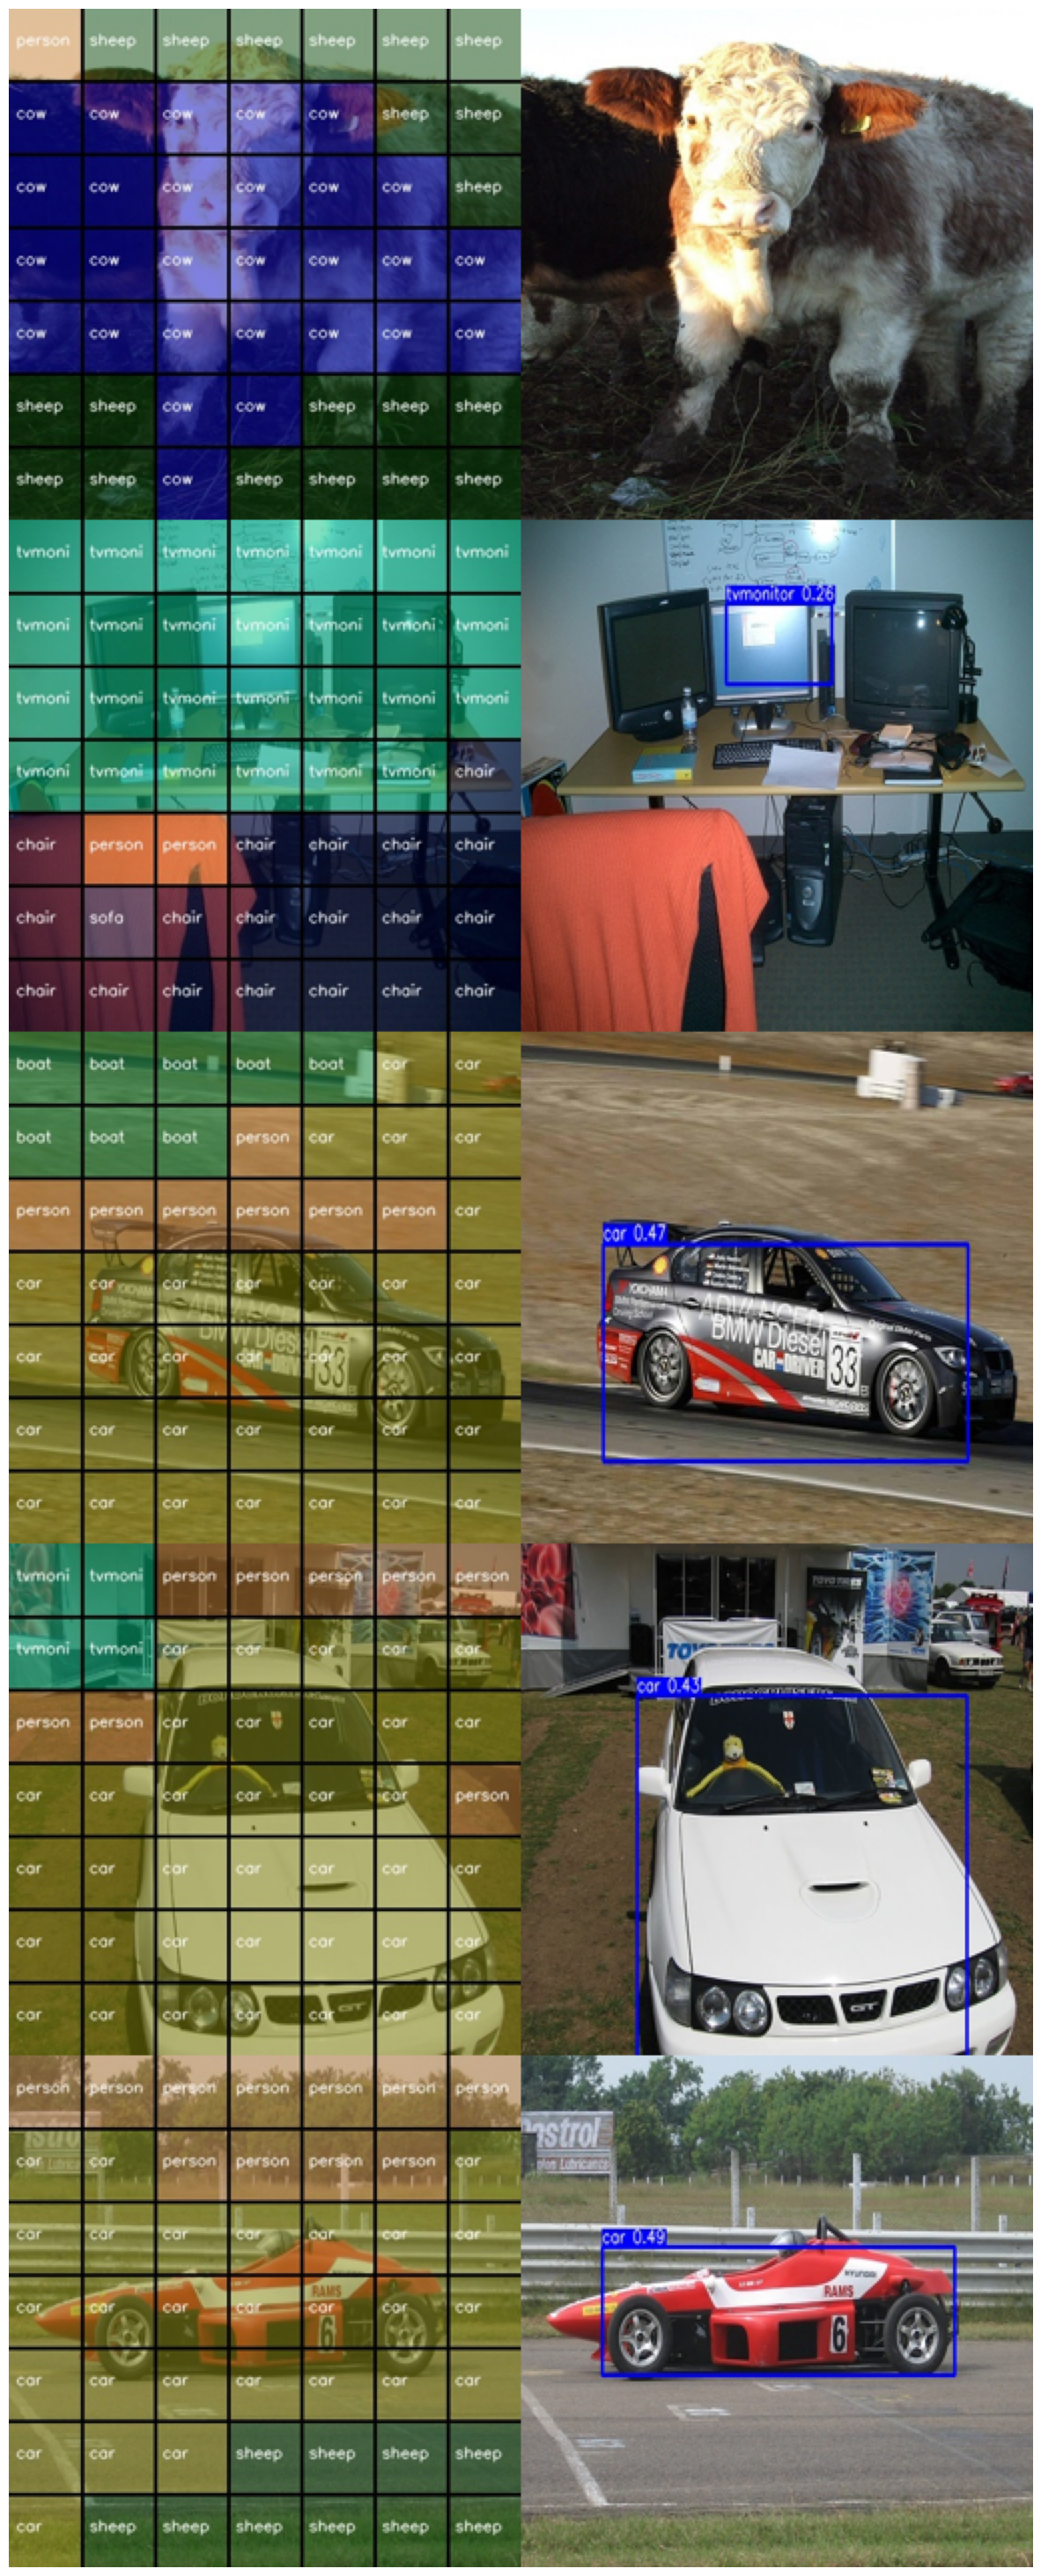

In [ ]:
import matplotlib.pyplot as plt
import os
# os.chdir('Yolov1-PyTorch')
from PIL import Image
import numpy as np

# Define paths
grid_cls_path = 'samples/grid_cls'  # Replace with the correct path
preds_path = 'samples/preds'        # Replace with the correct path

# Get image file names
grid_images = sorted(os.listdir(grid_cls_path))
pred_images = sorted(os.listdir(preds_path))

# Set target size (width, height) to which all images will be resized
target_size = (256, 256)  # You can adjust this as needed

# List to store stacked images
stacked_images = []

for i in range(len(grid_images)):
    # Load images and resize them to the target size
    grid_img = Image.open(os.path.join(grid_cls_path, grid_images[i])).resize(target_size)
    pred_img = Image.open(os.path.join(preds_path, pred_images[i])).resize(target_size)

    # Convert images to NumPy arrays
    grid_img_np = np.array(grid_img)
    pred_img_np = np.array(pred_img)

    # Horizontally stack the grid and prediction images
    hstacked = np.hstack((grid_img_np, pred_img_np))

    # Add the horizontally stacked image to the list
    stacked_images.append(hstacked)

# Vertically stack all the horizontally stacked images
vstacked_images = np.vstack(stacked_images)

# Show the final image
plt.figure(figsize=(15, 105))  # Adjust figure size based on image dimensions
plt.imshow(vstacked_images)
plt.axis('off')  # Turn off axis
plt.show()